[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mravanba/comp551-notebooks/blob/master/NumpyDeepMLP.ipynb)

# Deep Multilayer Perceptron (MLP)

Our goal here is to implement a framework for constructing deep neural networks. With this framework, we will train networks of various depth to perform classification on the Iris dataset.

In [2]:
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')

from typing import List
from tqdm import tqdm

## Neural Network Layers
We will construct MLPs as sequences of layers. Examples of such layers are:
- Linear layers, which compute an affine transformation of the previous layer neurons
- ReLU layers, which compute $\mathsf{ReLU}(x) = \max(0, x)$ for each neuron $x$ of the previous layer
- Softmax output layer, which computes the softmax of the previous layer neurons

Each layer has two main functions:

1. `forward`: given the previous layer neurons, compute the neurons for this layer
1. `backward`: given the gradients passed down from the next layer, compute the gradients for this layer's parameters (if applicable) as well as the gradients to pass down to the previous layer

Layers also maintain the following variables:
1. `self.parameters`: A list of parameters to be updated
1. `self.gradient`: Stores the gradient with respect to its parameters from the last forward pass. The gradient is stored as a list of gradients (one gradient per parameter in the `self.parameters` list).

For our purposes, the only type of layer that has updatable parameters is the linear layer.

In [3]:
class NeuralNetLayer:
    def __init__(self):
        self.gradient = None
        self.parameters = None
        
    def forward(self, x):
        raise NotImplementedError

    def backward(self, gradient):
        raise NotImplementedError

### The Linear Layer
The linear layer is characterized by the number of input neurons to the layer as well as the number of output neurons. Call these $n_i, n_o$ respectively. On input $x$, the linear layer computes

$$
x' = Wx + b
$$

where $W, b$ are the parameters of the layer. We must have $W\in\mathbf{R}^{n_o\times n_i}$ and $b\in\mathbf{R}^{n_o}$. We will initialize these parameters with independent standard Gaussian samples.

Note that the gradient of the linear layer with respect to $W$ depends on its input $x$. Therefore, during the forward pass, we will store the input in a variable `self.cur_input` so it can later be used in the gradient computation.

In [4]:
class LinearLayer(NeuralNetLayer):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.ni = input_size
        self.no = output_size
        self.w = np.random.randn(output_size, input_size)
        self.b = np.random.randn(output_size)
        self.cur_input = None
        self.parameters = [self.w, self.b]

    def forward(self, x):
        self.cur_input = x
        return (self.w[None, :, :] @ x[:, :, None]).squeeze() + self.b

    def backward(self, gradient):
        assert self.cur_input is not None, "Must call forward before backward"
        #dw = gradient.dot(self.cur_input)
        dw = gradient[:, :, None] @ self.cur_input[:, None, :]
        db = gradient
        self.gradient = [dw, db]
        return gradient.dot(self.w)

### The ReLU Layer

Unlike the linear layer, the ReLU layer doesn't maintain any parameters -- it simply computes a nonlinear function of its inputs. However, the gradient that flows through the ReLU layer depends on its inputs. Therefore, we can compute the gradient with respect to the inputs within the `forward` function and store it in `self.gradient`.

In [5]:
class ReLULayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        self.gradient = np.where(x > 0, 1.0, 0.0)
        return np.maximum(0, x)

    def backward(self, gradient):
        assert self.gradient is not None, "Must call forward before backward"
        return gradient * self.gradient

### The Softmax Output Layer

Like the ReLU layer, the softmax layer does not have any parameters to be tuned.

We will only be using the softmax layer as an output layer, and we will only be training with the cross-entropy loss for classification. The gradient of the combined cross-entropy loss and softmax is actually simpler than each of those gradients individually, so we will combine them in our `SoftmaxOutputLayer`. In particular, we have that

$$
\nabla_x\mathsf{CrossEntropyLoss}(\mathsf{Softmax}(x), y) = \mathsf{Softmax}(x) - y
$$

where $y$ is the target labels. So, in our implementation, the `backward` function of `SoftmaxOutputLayer` will take as input the labels $y$ and return $\nabla_x\mathsf{CrossEntropyLoss}(\mathsf{Softmax}(x), y)$. We will store the value of $\mathsf{Softmax}(x)$ in a variable `self.cur_probs` inside the `forward` method.

In [6]:
class SoftmaxOutputLayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()
        self.cur_probs = None

    def forward(self, x):
        exps = np.exp(x)
        probs = exps / np.sum(exps, axis=-1)[:, None]
        self.cur_probs = probs
        return probs

    def backward(self, target):
        assert self.cur_probs is not None, "Must call forward before backward"
        return self.cur_probs - target

## Tying the Layers Together: The MLP and Backpropagation

Given our `forward` and `backward` methods for the various layers that we made, the implementation of a MLP as well as backpropagation is fairly simple. To compute a prediction for an input $x$ with the MLP, we compute

$$
\hat{y} = \texttt{forward}_k(\texttt{forward}_{k-1}(\dots\texttt{forward}_1(x))\dots))
$$

where $\texttt{forward}_k$ represents the `forward` method of the $k$th layer in the MLP.

To perform backpropagation, we start at the *last* layer of the MLP (in our case, the `SoftmaxOutputLayer`), and compute $\texttt{backward}_N(\hat{y})$, where similarly $\texttt{backward}_k$ is the `backward` method of layer $k$. The output of this call is then passed as the input to $\texttt{backward}_{N-1}$, and so on, until we get to the first layer of the network. Note that during each call to `backward`, the respective layers are computing the gradients with respect to their parameters (when applicable) and storing them in their `gradient` variables.

**Recall**: The backpropagation algorithm serves the purpose of computing high-dimensional gradients via the chain rule. It *is not* in charge of updating the parameters -- this will be the job of the optimization algorithm which we will implement shortly.

In [7]:
class MLP:
    def __init__(self, *args: List[NeuralNetLayer]):
        self.layers = args

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, target):
        for layer in self.layers[::-1]:
            target = layer.backward(target)

## Network Optimization

Now that we're able to compute parameter gradients by backpropagation, we need a way to use those gradients to update the network parameters. There are many algorithms for achieving this, but we will simply implement Gradient Descent in this notebook. However, we will be implementing a generic interface for optimization algorithms, so it will be easy to integrate alternative optimizers if you so desire.

We will make an abstract `Optimizer` class that has the following functions:
- `update`: this method takes a set of parameters and a set of gradients, and uses the gradients to modify the parameters
- `step`: this method traverses over the layers of an MLP and applies `update` to each layer.

Thus, to implement a new optimization algorithm, one must simply make a subclass of `Optimizer` and implement the `update` method.

In [8]:
class Optimizer:
    def __init__(self, net: MLP):
        self.net = net

    def step(self):
        for layer in self.net.layers[::-1]:
            if layer.parameters is not None:
                self.update(layer.parameters, layer.gradient)

    def update(self, params, gradient):
        raise NotImplementedError

class GradientDescentOptimizer(Optimizer):
    def __init__(self, net: MLP, lr: float):
        super().__init__(net)
        self.lr = lr

    def update(self, params, gradient):
        for (p, g) in zip(params, gradient):
            p -= self.lr * g.mean(axis=0)

## Iris dataset
Let's apply this to do multiclass classification with Iris flowers dataset. 
We will begin by loading the dataset, and then we will train two MLPs on the data with different depths.

### Loading the data

In [21]:
from sklearn import datasets
dataset = datasets.load_iris()
x, y = dataset['data'][:,[1,2]], dataset['target']

n_features = x.shape[-1]

### The training loop
Here we'll build the loop that performs the gradient updates. The function will plot the training loss when it's done.

In [22]:
def train(mlp: MLP, optimizer: Optimizer, data_x, data_y, steps):
    losses = []
    labels = np.eye(3)[np.array(data_y)]
    for _ in tqdm(range(steps)):
        predictions = mlp.forward(data_x)
        loss = -(labels * np.log(predictions)).sum(axis=-1).mean()
        losses.append(loss)
        mlp.backward(labels)
        optimizer.step()
    plt.plot(losses)
    plt.xlabel("Epoch")
    plt.ylabel("Cross entropy loss")

### Visualization of the decision boundary

In [23]:
def plot_decision_boundary(mlp: MLP, data_x, data_y):
    x0v = np.linspace(np.min(data_x[:,0]), np.max(data_x[:,0]), 200)
    x1v = np.linspace(np.min(data_x[:,1]), np.max(data_x[:,1]), 200)
    x0,x1 = np.meshgrid(x0v, x1v)
    x_all = np.vstack((x0.ravel(),x1.ravel())).T
    yh_all = np.argmax(mlp.forward(x_all), axis=-1)
    plt.scatter(data_x[:,0], data_x[:,1], c=data_y, marker='o', alpha=1)
    plt.scatter(x_all[:,0], x_all[:,1], c=yh_all, marker='.', alpha=.01)
    plt.ylabel('sepal length')
    plt.xlabel('sepal width')
    plt.title('decision boundary of the MLP')
    plt.show()

### Building and training an MLP with one hidden layer

100%|█████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1726.59it/s]


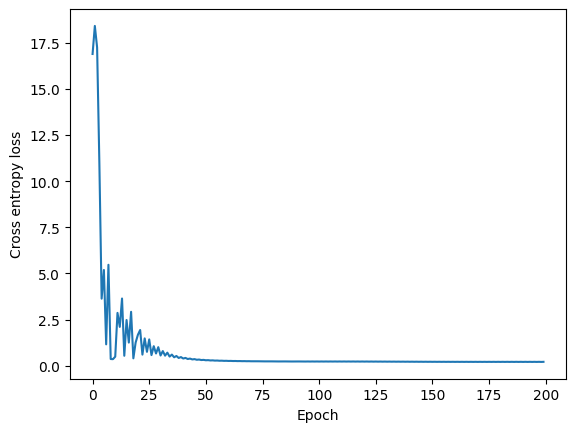

In [24]:
HIDDEN_SIZE = 32
GRADIENT_STEPS = 200

mlp1 = MLP(
    LinearLayer(n_features, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, 3),
    SoftmaxOutputLayer()
)
opt1 = GradientDescentOptimizer(mlp1, 1e-1)

train(mlp1, opt1, x, y, GRADIENT_STEPS)

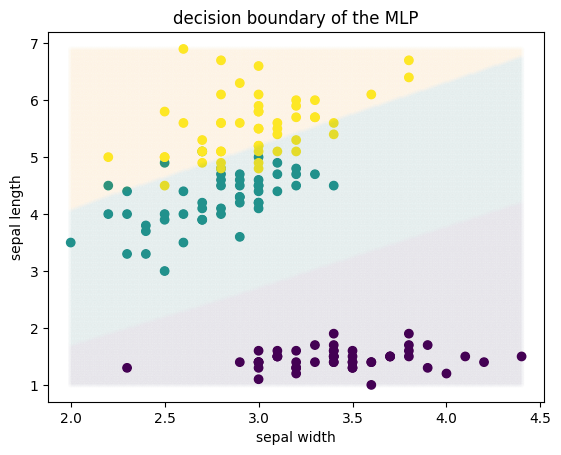

In [25]:
plot_decision_boundary(mlp1, x, y)

### Building and training an MLP with two hidden layers

100%|██████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 632.19it/s]


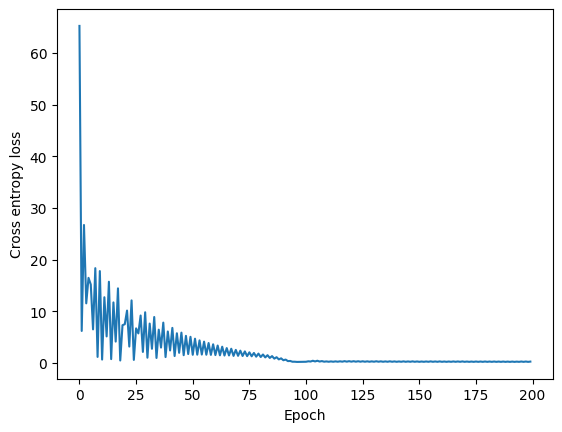

In [26]:
mlp2 = MLP(
    LinearLayer(n_features, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, 3),
    SoftmaxOutputLayer()
)
opt2 = GradientDescentOptimizer(mlp2, 1e-2)

train(mlp2, opt2, x, y, GRADIENT_STEPS)

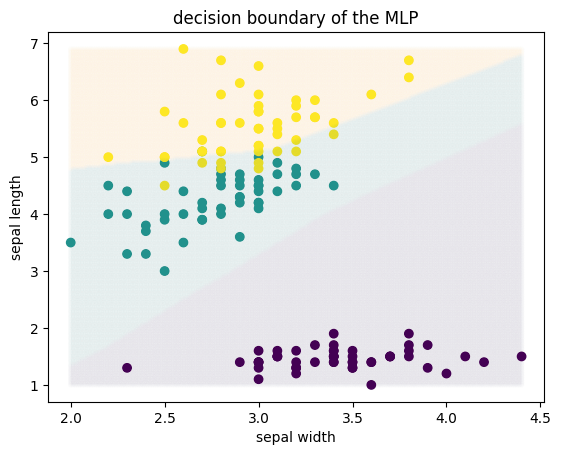

In [27]:
plot_decision_boundary(mlp2, x, y)